In [1]:
from benchmark import read_adult_data, read_mushroom_data, read_heart_data, train_faster_risk, run_fasterrisk_benchmark, read_bank_data, read_mammo_data, read_spam_data
# read_spam_data()[0].shape, read_adult_data()[0].shape, read
# _mushroom_data()[0].shape, read_mammo_data()[0].shape

In [1]:
import numpy as np
import pandas as pd
from fasterrisk.fasterrisk import RiskScoreClassifier, RiskScoreOptimizer
from sklearn.metrics import average_precision_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

from scorepyo.models import EBMRiskScoreNew
from scorepyo._utils import fast_numba_auc

from benchmark import read_adult_data, read_mushroom_data, read_heart_data, train_faster_risk, run_fasterrisk_benchmark, read_bank_data
from scorepyo.ranking import (
    BordaRank,
    CumulativeMetric,
    DiverseLogOddsDensity,
    FasterRiskRank,
    LarsPathRank,
    LassoPathRank,
    LogOddsDensity,
    OMPRank,
)


X,y,categorical_features = read_heart_data()
# X,y,categorical_features = read_mushroom_data()
# X,y,categorical_features = read_bank_data()

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

min_point_value = -2
max_point_value = 3
nb_max_features = 4

ebm_model = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=6,
)

# if use_calib:
#     X_train, X_calib, y_train, y_calib = train_test_split(
#         X_train_orig, y_train_orig, test_size=0.2, random_state=random_state_calib
#     )
# else:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_calib = X_train
y_calib = y_train

list_ranker = [DiverseLogOddsDensity(1), LogOddsDensity()]

for ranker in (BordaRank(list_ranker),
    CumulativeMetric(
                metric=fast_numba_auc, ranker=DiverseLogOddsDensity(1)
            ),
    DiverseLogOddsDensity(),
    DiverseLogOddsDensity(1),
    FasterRiskRank(
                min_point_value=-2,
                max_point_value=3,
                nb_max_features=4,
            ),
    LarsPathRank(),
    LassoPathRank(),
    LogOddsDensity(),
    OMPRank()):


    ebm_model.fit(
        X_train,
        y_train,
        X_calib=X_calib,
        y_calib=y_calib,
        categorical_features=categorical_features,
        sorting_method='fasterrisk',
        ranker=ranker
    )

binarizer = ebm_model._binarizer

X_train_binarized = binarizer.transform(X_train)
X_calib_binarized = binarizer.transform(X_calib)
X_test_binarized = binarizer.transform(X_test)

X_train_orig_binarized = binarizer.transform(X_train_orig)
y_train_fasterrisk = np.where(y_train_orig == 0, -1, 1)

faster_risk_model = train_faster_risk(
    X_train_orig_binarized,
    y_train_fasterrisk,
    min_point_value,
    max_point_value,
    nb_max_features,
)

# list_models = run_fasterrisk_benchmark(X_train_orig_binarized,
#     y_train_fasterrisk,
#     min_point_value,
#     max_point_value,
#     nb_max_features,
#     parent_size_range=[10],
#     child_size_range=(None,),
#     max_attempts_range=(50,),
#     num_ray_range=(10,),
#     lineSearch_early_stop_tolerance_range=(1e-3,),
#     )



y_proba_faster_risk_train_orig = faster_risk_model.predict_prob(
    X_train_orig_binarized.values
)
y_proba_faster_risk_train = faster_risk_model.predict_prob(X_train_binarized.values)
y_proba_faster_risk_calib = faster_risk_model.predict_prob(X_calib_binarized.values)
y_proba_faster_risk_test = faster_risk_model.predict_prob(X_test_binarized.values)

y_proba_ebm_train_orig = ebm_model.predict_proba(X_train_orig)[:, 1].reshape(-1, 1)
y_proba_ebm_train = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
y_proba_ebm_calib = ebm_model.predict_proba(X_calib)[:, 1].reshape(-1, 1)
y_proba_ebm_test = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)




c:\Users\S5384228\Anaconda3\envs\env_scorepyo_without_setuppy\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(216, 50)


In [ ]:
from fasterrisk.fasterrisk import RiskScoreClassifier, RiskScoreOptimizer
parent_size=10
child_size=None
max_attempts=50
num_ray=20
lineSearch_early_stop_tolerance=1e-3

RiskScoreOptimizer_m = RiskScoreOptimizer(
        X=X_train_orig_binarized.values,
        y=y_train_fasterrisk,
        lb=min_point_value,
        ub=max_point_value,
        k=nb_max_features,
        parent_size=parent_size,
        child_size=child_size,
        maxAttempts=max_attempts,
        num_ray_search=num_ray,
        lineSearch_early_stop_tolerance=lineSearch_early_stop_tolerance,
    )

RiskScoreOptimizer_m.sparseLogRegModel_object.get_sparse_sol_via_OMP(k=RiskScoreOptimizer_m.k, parent_size=RiskScoreOptimizer_m.parent_size, child_size=RiskScoreOptimizer_m.child_size)
        
beta0, betas, ExpyXB = RiskScoreOptimizer_m.sparseLogRegModel_object.get_beta0_betas_ExpyXB()
RiskScoreOptimizer_m.sparseDiversePoolLogRegModel_object.warm_start_from_beta0_betas_ExpyXB(beta0 = beta0, betas = betas, ExpyXB = ExpyXB)

sparseDiversePool_beta0, sparseDiversePool_betas = RiskScoreOptimizer_m.sparseDiversePoolLogRegModel_object.get_sparseDiversePool(gap_tolerance=RiskScoreOptimizer_m.sparseDiverseSet_gap_tolerance, select_top_m=RiskScoreOptimizer_m.sparseDiverseSet_select_top_m, maxAttempts=RiskScoreOptimizer_m.sparseDiverseSet_maxAttempts)

In [ ]:
features_sorted_by_occurence = sorted([(f,v) for f,v in zip(X_train_binarized.columns, np.sum((sparseDiversePool_betas!=0), axis=0))], key=lambda t: t[1])
chosen_features = [f for f,_ in features_sorted_by_occurence[-7:]]
chosen_features

['resting electrocardiographic results_1.0',
 'thal_3.0',
 '1.5 <= the slope of the peak exercise ST segment < 2.5',
 'chest pain type_4.0',
 'thal_7.0',
 'the slope of the peak exercise ST segment < 1.5',
 'number of major vessels (0-3) colored by flourosopy < 0.5']

In [ ]:
[(f,v) for f,v in zip(X_train_binarized.columns, sparseDiversePool_betas[0,:]) if v!=0]

[('the slope of the peak exercise ST segment < 1.5', -1.681497078226686),
 ('number of major vessels (0-3) colored by flourosopy < 0.5',
  -1.9347352175041916),
 ('chest pain type_4.0', 2.1257221377096815),
 ('thal_7.0', 1.8874188338801035)]

In [ ]:
import numpy.random

In [ ]:
from numpy.random import default_rng

df_cvx = ebm_model.df_cvx_debug.copy()
df_cvx['positive_count'] = df_cvx['target'] * df_cvx['count'] 
df_cvx['negative_count'] = df_cvx['count'] -  df_cvx['positive_count']

df_cvx['positive_proba'] = df_cvx['positive_count'] / df_cvx['count'].sum()
df_cvx['negative_proba'] = df_cvx['negative_count'] / df_cvx['count'].sum()
# from scipy.stats import multinomial
list_proba_multinomial = list(df_cvx['positive_proba'].values)
list_proba_multinomial += list(df_cvx['negative_proba'].values)

rng = default_rng()
nb_experiment = 1
size_sample = df_cvx['count'].sum()
bootstrap_samples = rng.multinomial(n=size_sample,pvals=list_proba_multinomial, size=nb_experiment)

positive_count_samples = bootstrap_samples[:,:len(df_cvx)].T
negative_count_samples = bootstrap_samples[:,len(df_cvx):].T
positive_col_bootstrap = [f'positive_count_{i}' for i in range(nb_experiment)]
negative_col_bootstrap = [f'negative_count_{i}' for i in range(nb_experiment)]
df_cvx[positive_col_bootstrap] = positive_count_samples
df_cvx[negative_col_bootstrap] = negative_count_samples
import cvxpy as cp
df_cvx



# # Compute number of positive and negative samples at each score value
# positive_sample_count = (
#     df_cvx["target"].values * df_cvx["count"].values
# ).astype(int)
# negative_sample_count = df_cvx["count"].values - positive_sample_count

# Declare the list of probabilities to be set as variables
list_proba = [cp.Variable(1) for _ in df_cvx.index]

# Compute total size of samples to normalize the logloss
total_count = df_cvx["count"].sum()

# Compute the logloss at each score in a list in order to sum it later
# the logloss at each score is simple as all samples will have the same
# probability p. for all positive samples, add -log(p), for all negative samples add -log(1-p)
list_bootstrap_sample_objective = []
for i in range(nb_experiment):
    positive_sample_count = df_cvx[f'positive_count_{i}'].values
    negative_sample_count = df_cvx[f'negative_count_{i}'].values
    list_expression = [
        -cp.log(p) * w_pos - cp.log(1 - p) * w_neg
        for p, w_pos, w_neg in zip(
            list_proba, positive_sample_count, negative_sample_count
        )
    ]
    list_bootstrap_sample_objective.append(list_expression.copy())
# objective = cp.Minimize(cp.sum(list_expression) / total_count)  # Objectiv

worse_log_loss = cp.Variable(1)
constraints = []
for p in list_proba:
    constraints.append(p >= 1e-5)
    constraints.append(p <= 0.9999999)
for i in range(1, len(list_proba)):
    # TODO : Put the threshold away and combine all similar scores into 1
    constraints.append(list_proba[i] - list_proba[i - 1] - 1e-3 >= 0)

optimize_method = 'mean'
#Optimize worst case
if optimize_method == 'worse':
    for single_bootstrap_logloss in list_bootstrap_sample_objective:
        constraints.append(worse_log_loss>=cp.sum(single_bootstrap_logloss)/total_count)
    objective = cp.Minimize(worse_log_loss)
elif optimize_method =='mean':
    objective = cp.Minimize(
                cp.sum(
                    [
                        cp.sum(single_bootstrap_logloss)@cp.sum(single_bootstrap_logloss)
                        for single_bootstrap_logloss in list_bootstrap_sample_objective
                    ]
                )
            )
elif optimize_method=='vanilla':
    # # Compute number of positive and negative samples at each score value
    positive_sample_count = (
        df_cvx["target"].values * df_cvx["count"].values
    ).astype(int)
    negative_sample_count = df_cvx["count"].values - positive_sample_count
    list_expression = [
            -cp.log(p) * w_pos - cp.log(1 - p) * w_neg
            for p, w_pos, w_neg in zip(
                list_proba, positive_sample_count, negative_sample_count
            )
        ]
    objective = cp.Minimize(cp.sum(list_expression) / total_count)  # Objectiv
else:
    raise Exception
problem = cp.Problem(objective, constraints)

opt = problem.solve(verbose=False)



DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
(-log(var13221) @ 1.0 + -log(1.0 + -var13221) @ 49.0 + -log(var13222) @ 1.0 + -log(1.0 + -var13222) @ 23.0 + -log(var13223) @ 3.0 + -log(1.0 + -var13223) @ 29.0 + -log(var13224) @ 11.0 + -log(1.0 + -var13224) @ 21.0 + -log(var13225) @ 9.0 + -log(1.0 + -var13225) @ 6.0 + -log(var13226) @ 27.0 + -log(1.0 + -var13226) @ 1.0 + -log(var13227) @ 5.0 + -log(1.0 + -var13227) @ 1.0 + -log(var13228) @ 27.0 + -log(1.0 + -var13228) @ 2.0) @ (-log(var13221) @ 1.0 + -log(1.0 + -var13221) @ 49.0 + -log(var13222) @ 1.0 + -log(1.0 + -var13222) @ 23.0 + -log(var13223) @ 3.0 + -log(1.0 + -var13223) @ 29.0 + -log(var13224) @ 11.0 + -log(1.0 + -var13224) @ 21.0 + -log(var13225) @ 9.0 + -log(1.0 + -var13225) @ 6.0 + -log(var13226) @ 27.0 + -log(1.0 + -var13226) @ 1.0 + -log(var13227) @ 5.0 + -log(1.0 + -var13227) @ 1.0 + -log(var13228) @ 27.0 + -log(1.0 + -var13228) @ 2.0)

In [ ]:
cp.sum(list_bootstrap_sample_objective[0]) @ cp.sum(list_bootstrap_sample_objective[0])

Expression(UNKNOWN, UNKNOWN, ())

In [ ]:
[p.value[0] for p in list_proba]

[0.0465116279559026,
 0.09090909106151687,
 0.1250000003192319,
 0.4666666665604354,
 0.578947368497773,
 0.9185934043010464,
 0.9195934047792689,
 0.9599999998485931]

In [ ]:
[p.value[0] for p in list_proba]

[0.09311419752837176,
 0.0941141975360317,
 0.20211377341330602,
 0.4812277146103977,
 0.5118485991796771,
 0.9137196902374992,
 0.9147196902771089,
 0.9284886283778573]

In [ ]:
[p.value[0] for p in list_proba]

[0.0419091962293136,
 0.09977827054733106,
 0.11248454886405221,
 0.46921797004425125,
 0.5854341736479275,
 0.9216380800440064,
 0.9226380800668597,
 0.9356725146947004]

In [ ]:

# multinomial(10,list_proba)


ModuleNotFoundError: No module named 'numpy.random.Generator'

In [ ]:
proba_faster_risk = [
    y_proba_faster_risk_train_orig,
    # y_proba_faster_risk_train,
    # y_proba_faster_risk_calib,
    y_proba_faster_risk_test,
]
proba_ebm = [
    y_proba_ebm_train_orig,
    # y_proba_ebm_train,
    # y_proba_ebm_calib,
    y_proba_ebm_test,
]

targets = [
    y_train_orig, 
    # y_train, y_calib,
            y_test]

metrics = [log_loss, average_precision_score, roc_auc_score]

data_metrics = []
for list_y_probas in [proba_faster_risk, proba_ebm]:
    data_metrics_ = []
    for y_proba, y_true in zip(list_y_probas, targets):
        for metric in metrics:
            data_metrics_.append(metric(y_true.astype(int), y_proba))
    data_metrics.append(data_metrics_.copy())

data_metrics


[[0.28728198983995984,
  0.36319400280730213,
  0.7622208302448278,
  0.2963139581663357,
  0.32867922971187075,
  0.7487466242511439],
 [0.2853980296112021,
  0.36604767530279686,
  0.7761308481846959,
  0.2936330791782184,
  0.333893116769875,
  0.7677251138025378]]

In [ ]:
# from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA

# pca = PCA(n_components=10)
# spca = SparsePCA(n_components=10,alpha=6.5)
# mbspca = MiniBatchSparsePCA(n_components=10,alpha=3)

# # pca.fit(X_train_binarized)
# spca.fit(X_train_binarized)
# mbspca.fit(X_train_binarized)

In [ ]:
# mbspca.components_
# sum_pca_components = np.abs(spca.components_).sum(axis=0)

In [ ]:
# sum_pca_components

In [ ]:
# order_features = np.argsort(sum_pca_components)

In [ ]:
# X_train_binarized.columns[order_features[::-1]]

In [ ]:
# spca.components_.shape

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_binarized, y_train)

In [ ]:
# clf._

In [ ]:
ebm_model.summary()

| FEATURE-POINT CARD |
| Feature                   | Description               | Point(s)   |       |
|:--------------------------|:--------------------------|:-----------|:------|
| cons_price_idx_geq_93_5_0 | cons_price_idx_geq_93_5_0 | -2.0       | ...   |
| call_in_Q2_0              | call_in_Q2_0              | 3.0        | + ... |
| emp_var_rate_lt_n1_1      | emp_var_rate_lt_n1_1      | 3.0        | + ... |
| nr_employed_lt_5100_1     | nr_employed_lt_5100_1     | 3.0        | + ... |
|                           |                           | SCORE=     | ...   |


|     SCORE CARD     |
| SCORE   | -2.0   | -1.0   | 0.0   | 1.0   | 2.0   | 3.0   | 4.0    | 5.0    | 6.0    | 7.0    | 8.0    | 9.0    |
|:--------|:-------|:-------|:------|:------|:------|:------|:-------|:-------|:-------|:-------|:-------|:-------|
| RISK    | 2.23%  | 3.02%  | 3.55% | 4.99% | 6.02% | 6.79% | 13.39% | 33.56% | 44.51% | 44.61% | 48.04% | 51.43% |


In [ ]:
X_featureNames = list(X_train_binarized.columns[:])

faster_risk_model.reset_featureNames(X_featureNames)
faster_risk_model.print_model_card()

# faster_risk_model.print_model_card(X_train_binarized.columns)

The Risk Score is:
1.                     call_in_Q1_0     -1 point(s) |   ...
2.                  called_before_0     -2 point(s) | + ...
3.            nr_employed_gt_5100_1     -1 point(s) | + ...
4.              euribor3m_geq_100_0      1 point(s) | + ...
                                              SCORE | =    
SCORE |  -4.0  |  -3.0  |  -2.0  |
RISK  |   5.3% |  12.7% |  27.6% |
SCORE |  -1.0  |   0.0  |   1.0  |
RISK  |  50.0% |  72.4% |  87.3% |


In [ ]:
scorepyo_features_bank = ['cons_price_idx_geq_93_5_0', 'call_in_Q2_0', 'emp_var_rate_lt_n1_1', 'nr_employed_lt_5100_1']
fasterrisk_features_bank = ['call_in_Q1_0', 'called_before_0', 'nr_employed_gt_5100_1', 'euribor3m_geq_100_0']

# TODO 15/02/23

* test new formula to see if its better - Done
* check where the fasterrisk features lies in the ranking
* think about biobjective space and pareto front with weight preference 
* look at correlated features and take one of cluster with hierarchical clustering - Done

# TODO 17/02/2023

* compute unique logodds score according to ranked features 

X * logodds[:n] padded with 0 and look at number of unique values
- > when numbers of unique logodds value do not vary enough, delete features from ranking

In [ ]:
import pandas

# Test logloss computation



In [ ]:
data_log_odds = ebm_model._binarizer.df_score_feature
data_log_odds = data_log_odds.sort_values(by=["prio", "log_odds_sum"], ascending=[False, False])
features_sorted = data_log_odds.index[:-1]
log_odds_vector = data_log_odds.loc[features_sorted,'EBM_log_odds_contribution'].values
log_odds_vector = log_odds_vector.reshape(-1,1)
log_odds_matrix = np.tile(log_odds_vector, reps=(1,len(features_sorted)))
for i in range(len(features_sorted)):
    log_odds_matrix[i+1:, i] = 0
# tril_matrix = np.einsum(,data_log_odds.loc[features_sorted,'EBM_log_odds_contribution'].values, )
# for i in range(len(feature_sorted)-1):
    
#     log_odds = data_log_odds.loc[feature_sorted]['EBM_log_odds_contribution'].values
#     log_odds[-i:] = 0

#     pred_log_odd = np.matmul(X_train_binarized[feature_sorted].values, log_odds)+data_sb.loc['intercept']['EBM_log_odds_contribution']

# Test cumulative integration of features

In [ ]:
data_log_odds = ebm_model._binarizer.df_score_feature
data_log_odds = data_log_odds.sort_values(by=["prio", "log_odds_sum"], ascending=[False, False])
features_sorted = data_log_odds.index[:-1]
log_odds_vector = data_log_odds.loc[features_sorted,'EBM_log_odds_contribution'].values
log_odds_vector = log_odds_vector.reshape(-1,1)
log_odds_matrix = np.tile(log_odds_vector, reps=(1,len(features_sorted)))
tril_log_odds_matrix = log_odds_matrix.copy()
eye_log_odds_matrix = log_odds_matrix.copy()
for i in range(len(features_sorted)):
    tril_log_odds_matrix[i+1:, i] = 0

for i in range(len(features_sorted)):
    eye_log_odds_matrix[i+1:, i] = 0
    eye_log_odds_matrix[:i, i] = 0

# tril_matrix = np.einsum(,data_log_odds.loc[features_sorted,'EBM_log_odds_contribution'].values, )
# for i in range(len(feature_sorted)-1):
    
#     log_odds = data_log_odds.loc[feature_sorted]['EBM_log_odds_contribution'].values
#     log_odds[-i:] = 0

#     pred_log_odd = np.matmul(X_train_binarized[feature_sorted].values, log_odds)+data_sb.loc['intercept']['EBM_log_odds_contribution']

In [ ]:
cumulative_log_odds = np.matmul(X_train_binarized[features_sorted].values, tril_log_odds_matrix)
unit_log_odds = np.matmul(X_train_binarized[features_sorted].values, eye_log_odds_matrix)

from collections import Counter
from scipy.stats import entropy
from scorepyo._utils import fast_numba_auc



def shannon_entropy(l):
    # print(list(Counter(l).values()))
    return entropy(list(Counter(l).values()))

def roc_auc_1d(l):
    return fast_numba_auc(y_train.astype(float).values,np.array(l, dtype=float))

def log_loss_1d(l):
    return np.mean(np.log(1+np.exp(y_train.astype(float).values*np.array(l, dtype=float))))
# lambda col: 

cumulative_shannon_entropy = np.apply_along_axis(shannon_entropy,axis=0,arr=cumulative_log_odds)
diff_cumulative_shannon_entropy = [t - s for s, t in zip(cumulative_shannon_entropy, cumulative_shannon_entropy[1:])]
diff_cumulative_shannon_entropy = [diff_cumulative_shannon_entropy[0]]+diff_cumulative_shannon_entropy


cumulative_roc_auc= np.apply_along_axis(roc_auc_1d,axis=0,arr=cumulative_log_odds)
diff_cumulative_roc_auc = [t - s for s, t in zip(cumulative_roc_auc, cumulative_roc_auc[1:])]
diff_cumulative_roc_auc = [diff_cumulative_roc_auc[0]]+diff_cumulative_roc_auc

cumulative_log_loss = np.apply_along_axis(log_loss_1d,axis=0,arr=cumulative_log_odds)
diff_cumulative_log_loss = [t - s for s, t in zip(cumulative_log_loss, cumulative_log_loss[1:])]
diff_cumulative_log_loss = [diff_cumulative_log_loss[0]]+diff_cumulative_log_loss

# unit_log_loss = np.apply_along_axis(log_loss_1d,axis=0,arr=unit_log_odds)
# diff_cumulative_log_loss = [t - s for s, t in zip(cumulative_log_loss, cumulative_log_loss[1:])]
# diff_cumulative_log_loss = [diff_cumulative_log_loss[0]]+diff_cumulative_log_loss

In [ ]:
log_loss_1d(cumulative_log_odds[:,2])

0.689682988445823

In [ ]:
idx_sorted_features_roc_auc_diff = np.argsort(np.array(diff_cumulative_roc_auc))[::-1]
new_idx = features_sorted[idx_sorted_features_roc_auc_diff]

idx_sorted_features_log_loss_diff = np.argsort(np.array(diff_cumulative_log_loss))
new_idx = features_sorted[idx_sorted_features_log_loss_diff]

new_idx = list(new_idx)+['intercept']
# new_idx.append('intercept')
data_log_odds.loc[new_idx,:]

,EBM_log_odds_contribution,lower_threshold,upper_threshold,category_value,feature,type,density,abs_contribution,log_odds_sum,absolute_log_odds,prio
binary_feature,,,,,,,,,,,
call_in_Q2_1,-0.120988,None,None,1,call_in_Q2,categorical,17346,1288.19914,2098.664285,0.120988,0
calls_b4_campaign_failed_1,-0.358826,None,None,1,calls_b4_campaign_failed,categorical,3397,811.753637,1218.930714,0.358826,1
euribor3m_geq_100_1,-0.055481,None,None,1,euribor3m_geq_100,categorical,29819,988.362277,1654.401118,0.055481,0
call_on_mon_1,-0.130264,None,None,1,call_on_mon,categorical,6796,569.460458,885.271008,0.130264,0
call_in_Q4_0,-0.024497,None,None,0,call_in_Q4,categorical,28905,423.681834,708.090051,0.024497,0
...,...,...,...,...,...,...,...,...,...,...,...
euribor3m_geq_300_0,0.155142,None,None,0,euribor3m_geq_300,categorical,10766,1049.978733,1670.256696,0.155142,0
calls_b4_campaign_successful_1,0.678811,None,None,1,calls_b4_campaign_successful,categorical,1111,531.101079,754.158945,0.678811,1
euribor3m_geq_100_0,0.528394,None,None,0,euribor3m_geq_100,categorical,3131,1106.258604,1654.401118,0.528394,1


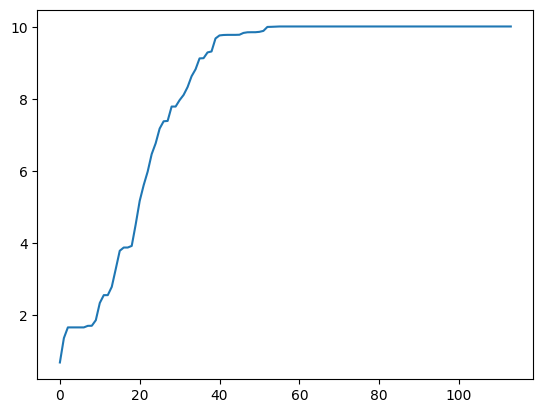

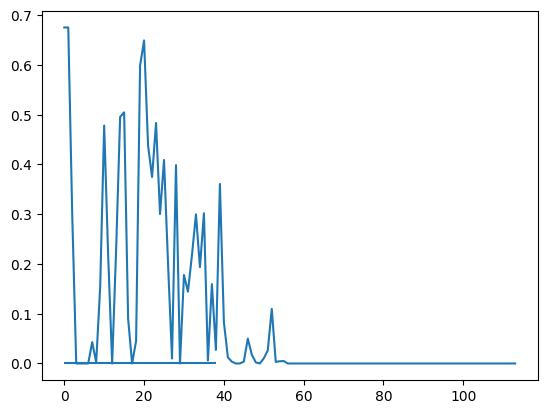

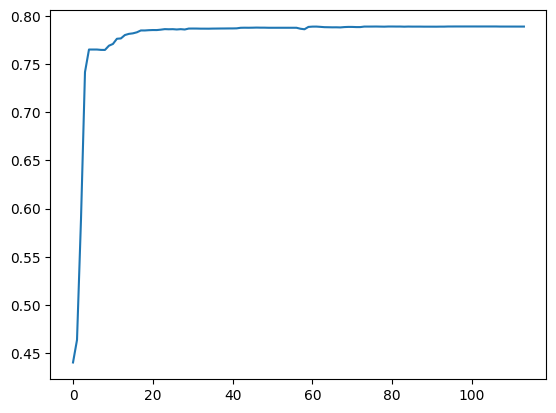

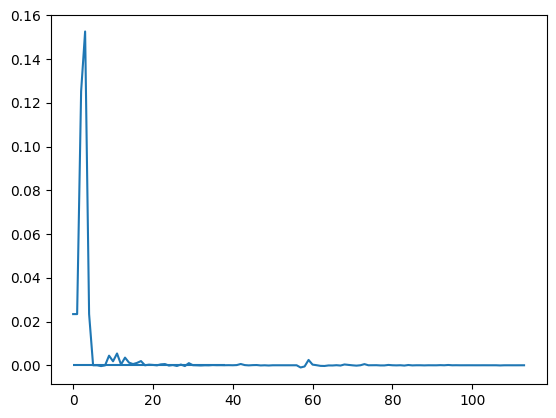

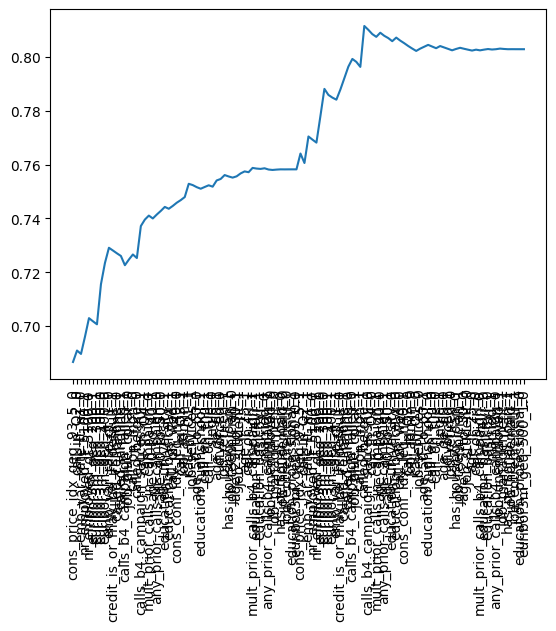

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113],
 [Text(0, 0, 'cons_price_idx_geq_93_5_0'),
  Text(1, 0, 'call_in_Q2_0'),
  Text(2, 0, 'emp_var_rate_lt_n1_0'),
  Text(3, 0, 'nr_employed_lt_5100_1'),
  Text(4, 0, 'nr_employed_gt_5100_0'),
  Text(5, 0, 'euribor3m_geq_200_1'),
  Text(6, 0, 'euribor3m_geq_300_1'),
  Text(7, 0, 'euribor3m_geq_100_0'),
  Text(8, 0

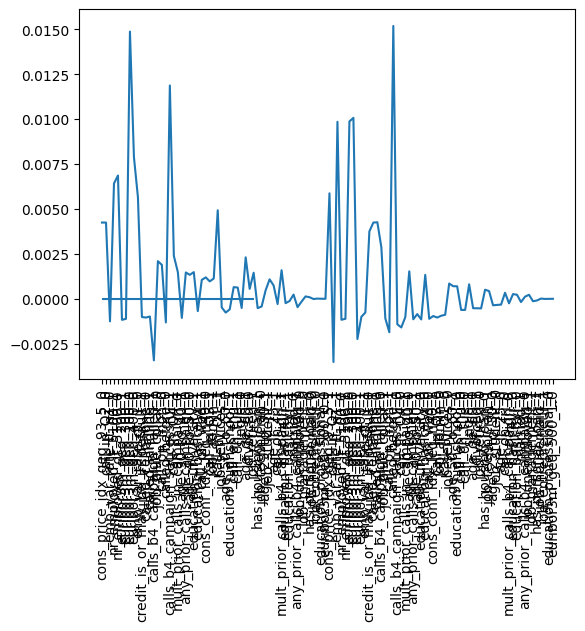

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cumulative_shannon_entropy)
plt.show()
plt.plot(diff_cumulative_shannon_entropy)
plt.hlines(xmin=0,xmax=38,y=0)
plt.show()

plt.plot(cumulative_roc_auc)
plt.show()
plt.plot(diff_cumulative_roc_auc)
plt.hlines(xmin=0,xmax=38,y=0)
plt.show()

plt.plot(features_sorted, cumulative_log_loss)
plt.xticks(rotation=90)
plt.show()
plt.plot(features_sorted, diff_cumulative_log_loss)
plt.hlines(xmin=0,xmax=38,y=0)
plt.xticks(rotation=90)

In [ ]:
ebm_model._binarizer.df_score_feature.sort_values(by='abs_contribution', ascending=False)

,EBM_log_odds_contribution,lower_threshold,upper_threshold,category_value,feature,type,density,abs_contribution,log_odds_sum,absolute_log_odds,prio
binary_feature,,,,,,,,,,,
cons_price_idx_geq_93_5_0,-0.200143,None,None,0,cons_price_idx_geq_93_5,categorical,16356,2015.271034,3273.537481,0.200143,1
cons_price_idx_geq_93_5_1,0.197272,None,None,1,cons_price_idx_geq_93_5,categorical,16594,2013.815891,3273.537481,0.197272,0
call_in_Q2_0,0.134495,None,None,0,call_in_Q2,categorical,15604,1295.034012,2098.664285,0.134495,1
call_in_Q2_1,-0.120988,None,None,1,call_in_Q2,categorical,17346,1288.19914,2098.664285,0.120988,0
euribor3m_geq_100_0,0.528394,None,None,0,euribor3m_geq_100,categorical,3131,1106.258604,1654.401118,0.528394,1
...,...,...,...,...,...,...,...,...,...,...,...
education_professional_1,0.000312,None,None,1,education_professional,categorical,4173,0.858186,1.301978,0.000312,1
education_professional_0,-0.000045,None,None,0,education_professional,categorical,28777,0.779204,1.301978,0.000045,0
euribor3m_geq_500_0.0,0.0,None,None,0.0,euribor3m_geq_500,categorical,32941,0.0,0.0,0.0,1


In [ ]:
features_scorepyo

{'call_in_Q2_0',
 'cons_price_idx_geq_93_5_0',
 'emp_var_rate_lt_n1_1',
 'nr_employed_lt_5100_1'}

In [ ]:
features_fasterrisk

{'call_in_Q1_0',
 'called_before_0',
 'euribor3m_geq_100_0',
 'nr_employed_gt_5100_1'}

In [ ]:
features_scorepyo&features_fasterrisk

set()

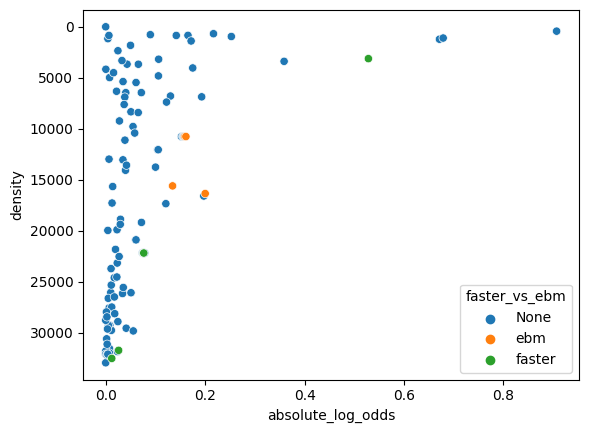

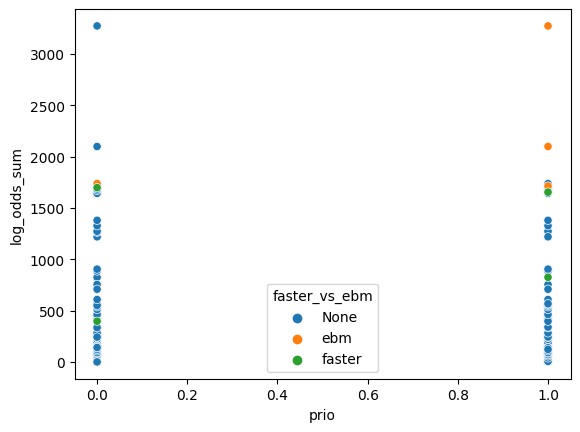

In [ ]:
import seaborn as sb 

data_sb = ebm_model._binarizer.df_score_feature.sort_values(by='abs_contribution', ascending=False)


data_sb['absolute_log_odds'] = data_sb['EBM_log_odds_contribution'].abs()

features_fasterrisk = set(["number of major vessels (0-3) colored by flourosopy < 0.5",
                     "the slope of the peak exercise ST segment < 1.5",
                       "chest pain type_4.0", "thal_7.0"])

features_scorepyo = set(["number of major vessels (0-3) colored by flourosopy < 0.5",
                     "the slope of the peak exercise ST segment < 1.5",
                       "chest pain type_4.0", "thal_7.0"])
best_features = set(["number of major vessels (0-3) colored by flourosopy < 0.5",
                     "the slope of the peak exercise ST segment < 1.5",
                       "chest pain type_4.0", "thal_7.0"])

features_fasterrisk = set(fasterrisk_features_bank)
features_scorepyo = set(scorepyo_features_bank)

cond_list = [data_sb.index.isin(features_fasterrisk-features_scorepyo),
             data_sb.index.isin(features_scorepyo-features_fasterrisk),
             data_sb.index.isin(features_scorepyo&features_fasterrisk)]
value_list = ['faster','ebm','both']

data_sb['faster_vs_ebm'] = np.select(cond_list, value_list,default='None')

sb.scatterplot(data=data_sb.sort_values(by='faster_vs_ebm', ascending=True), x='absolute_log_odds', y='density', hue="faster_vs_ebm")
plt.show()
sb.scatterplot(data=data_sb.sort_values(by='faster_vs_ebm', ascending=True), x='prio', y='log_odds_sum', hue="faster_vs_ebm")
plt.show()
# sb.scatterplot(data=data_sb.sort_values(by='faster_vs_ebm', ascending=True), x='absolute_log_odds', y='density', hue="abs_contribution")


In [ ]:
features_fasterrisk-features_scorepyo

{'odor_eq_none_0', 'stalk_surface_above_ring_eq_grooves_1'}

In [ ]:
data_sb[data_sb.index.isin(features_fasterrisk|features_scorepyo)][['absolute_log_odds', 'density','faster_vs_ebm']]

,absolute_log_odds,density,faster_vs_ebm
binary_feature,,,
odor_eq_foul_1,4.692819,1727,both
odor_eq_none_0,2.028376,3681,faster
gill_color_eq_buff_1,4.603746,1411,ebm
population_eq_solitary_1,2.777106,1376,ebm
gill_size_eq_narrow_1,1.726338,2042,both
stalk_surface_above_ring_eq_grooves_1,1.44593,1898,faster


In [ ]:
fr_features = ['odor_eq_none_0',
'odor_eq_foul_1',  
'gill_size_eq_narrow_1',    
'stalk_surface_above_ring_eq_grooves_1']


In [ ]:
from scorepyo._utils import fast_numba_auc
data_sb = data_sb.sort_values(by='log_odds_sum', ascending=False)

feature_sorted = [f for f in data_sb.index if f in X_featureNames]

l_roc_auc = []

for i in range(len(feature_sorted)-1):
    
    log_odds = data_sb.loc[feature_sorted]['EBM_log_odds_contribution'].values
    log_odds[-i:] = 0

    pred_log_odd = np.matmul(X_train_binarized[feature_sorted].values, log_odds)+data_sb.loc['intercept']['EBM_log_odds_contribution']
    pred_log_odd=pred_log_odd.astype(float)

    roc_auc = fast_numba_auc(y_train.astype(float).values,pred_log_odd)
    l_roc_auc.append(roc_auc)
    print(i, roc_auc)

0 0.5
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 0.9999858764345372
43 0.9999859712235671
44 0.9999860660125971
45 0.999986160801627
46 0.999986160801627
47 0.999986160801627
48 0.9999837910758782
49 0.9999840754429681
50 0.9999840754429681
51 0.9999836014978183
52 0.9999836014978183
53 0.9999836014978183
54 0.9999836014978183
55 0.9999836014978183
56 0.9999836014978183
57 0.9999839806539381
58 1.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 1.0
66 1.0
67 1.0
68 1.0
69 1.0
70 1.0
71 1.0
72 1.0
73 1.0
74 0.9999798099366203
75 0.9999798099366203
76 0.9999798099366203
77 0.9999798099366203
78 0.9999798099366203
79 0.9999799047256502
80 0.9999904263079749
81 0.9999907106750647
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'spore_print_color_eq_brown_1'),
  Text(1, 0, 'spore_print_color_eq_brown_0'),
  Text(2, 0, 'stalk_surface_above_ring_eq_grooves_1'),
  Text(3, 0, 'stalk_surface_above_ring_eq_grooves_0'),
  Text(4, 0, 'stalk_root_eq_bulbous_0'),
  Text(5, 0, 'stalk_root_eq_bulbous_1'),
  Text(6, 0, 'gill_size_eq_broad_1'),
  Text(7, 0, 'gill_size_eq_broad_0'),
  Text(8, 0, 'gill_size_eq_narrow_0'),
  Text(9, 0, 'gill_size_eq_narrow_1'),
  Text(10, 0, 'population_eq_solitary_0'),
  Text(11, 0, 'population_eq_solitary_1'),
  Text(12, 0, 'ring_type_eq_large_0'),
  Text(13, 0, 'ring_type_eq_large_1'),
  Text(14, 0, 'gill_color_eq_buff_0'),
  Text(15, 0, 'gill_color_eq_buff_1'),
  Text(16, 0, 'odor_eq_none_0'),
  Text(17, 0, 'odor_eq_none_1'),
  Text(18, 0, 'odor_eq_foul_0'),
  Text(19, 0, 'odor_eq_foul_1')])

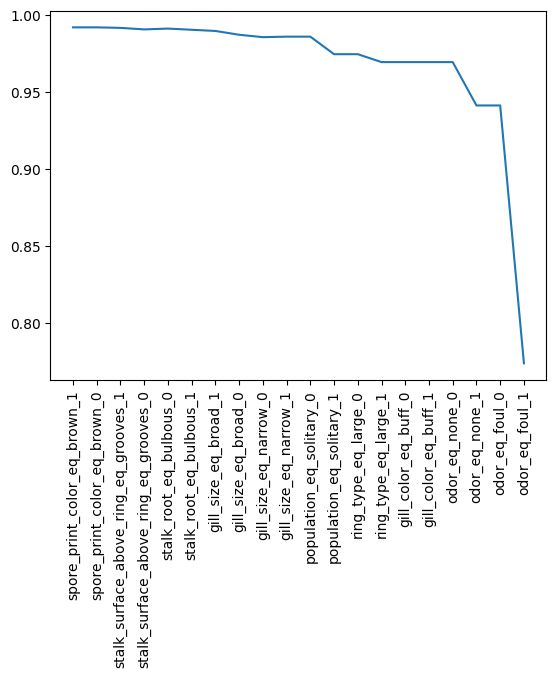

In [ ]:
import matplotlib.pyplot as plt

plt.plot(
    feature_sorted[:20][::-1],
         l_roc_auc[-20:])
plt.xticks(rotation=90)

In [ ]:
feature_sorted

['odor_eq_foul_1',
 'odor_eq_foul_0',
 'odor_eq_none_1',
 'odor_eq_none_0',
 'gill_color_eq_buff_1',
 'gill_color_eq_buff_0',
 'ring_type_eq_large_1',
 'ring_type_eq_large_0',
 'population_eq_solitary_1',
 'population_eq_solitary_0',
 'gill_size_eq_narrow_1',
 'gill_size_eq_narrow_0',
 'gill_size_eq_broad_0',
 'gill_size_eq_broad_1',
 'stalk_root_eq_bulbous_1',
 'stalk_root_eq_bulbous_0',
 'stalk_surface_above_ring_eq_grooves_0',
 'stalk_surface_above_ring_eq_grooves_1',
 'spore_print_color_eq_brown_0',
 'spore_print_color_eq_brown_1',
 'odor_eq_spicy_1',
 'odor_eq_spicy_0',
 'odor_eq_fishy_0',
 'odor_eq_fishy_1',
 'stalk_color_below_ring_eq_gray_0',
 'stalk_color_below_ring_eq_gray_1',
 'spore_print_color_eq_chocolate_1',
 'spore_print_color_eq_chocolate_0',
 'stalk_color_above_ring_eq_gray_1',
 'stalk_color_above_ring_eq_gray_0',
 'stalk_shape_eq_elarging_1',
 'stalk_shape_eq_elarging_0',
 'stalk_shape_eq_tapering_0',
 'stalk_shape_eq_tapering_1',
 'stalk_root_eq_club_0',
 'stalk_roo

In [ ]:
ebm_model = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=6,
    optimization_metric="roc_auc",
)
ebm_model.fit_dask_2(
    X_train,
    y_train,
    X_calib=X_calib,
    y_calib=y_calib,
    categorical_features=categorical_features,
    sorting_method='vanilla'
)

proba_vanilla = [ebm_model.predict_proba(X_train_orig)[:,1],
                  ebm_model.predict_proba(X_test)[:,1]]

ebm_model.fit_dask_2(
    X_train,
    y_train,
    X_calib=X_calib,
    y_calib=y_calib,
    categorical_features=categorical_features,
    sorting_method='new',
    fit_binarizer=False
)

proba_new = [ebm_model.predict_proba(X_train_orig)[:,1],
                  ebm_model.predict_proba(X_test)[:,1]]

targets = [
    y_train_orig, 
    # y_train, y_calib,
            y_test]

metrics = [log_loss, average_precision_score, roc_auc_score]

data_metrics = []
for list_y_probas in [proba_vanilla, proba_new, proba_faster_risk]:
    data_metrics_ = []
    for y_proba, y_true in zip(list_y_probas, targets):
        for metric in metrics:
            data_metrics_.append(metric(y_true.astype(int), y_proba))
    data_metrics.append(data_metrics_.copy())

data_metrics

C:\Users\S5384228\Documents\Private\scorepyo\scorepyo\core_module\scorepyo\models.py:2523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sense["lower_bound_point"] = np.where(
C:\Users\S5384228\Documents\Private\scorepyo\scorepyo\core_module\scorepyo\models.py:2528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sense["upper_bound_point"] = np.where(


Preparation: 0.6923058032989502
Preparation compute: 0.02667522430419922
Dask+AUC: 12.542747020721436
calibration: 0.16375231742858887


C:\Users\S5384228\Documents\Private\scorepyo\scorepyo\core_module\scorepyo\models.py:2523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sense["lower_bound_point"] = np.where(
C:\Users\S5384228\Documents\Private\scorepyo\scorepyo\core_module\scorepyo\models.py:2528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sense["upper_bound_point"] = np.where(


Preparation: 0.7032351493835449
Preparation compute: 0.04325461387634277
Dask+AUC: 15.032763004302979
calibration: 0.23869657516479492


[[0.15978500333139536,
  0.9673205974270452,
  0.9754622955779779,
  0.15726393380341347,
  0.9657815214402695,
  0.976508960115779],
 [0.12230322482503364,
  0.9812666616420326,
  0.9862787665748097,
  0.11048536749532678,
  0.9851065857651258,
  0.9893653732722818],
 [0.1316639009051057,
  0.9802438318310526,
  0.9829414818027811,
  0.11774151387796135,
  0.9838289788899106,
  0.9868760299420496]]

In [ ]:
for i in [1,3,5,10,20]:
    print(i)
    ebm_model.nb_additional_features = i

    ebm_model.fit(
        X_train,
        y_train,
        X_calib=X_calib,
        y_calib=y_calib,
        categorical_features=categorical_features,
        fit_binarizer=False
    )
    print()

In [ ]:
import time
X_train_orig_binarized = binarizer.transform(X_train_orig)
y_train_fasterrisk = np.where(y_train_orig == 0, -1, 1)

start_faster = time.time()
faster_risk_model = train_faster_risk(
    X_train_orig_binarized,
    y_train_fasterrisk,
    min_point_value,
    max_point_value,
    nb_max_features,
)
end_faster = time.time()
print(end_faster-start_faster)

In [ ]:
nb_max_features = 4
for nb_additional_features in [ 5
# ,6,7, 10
]:
    
    print("nb_additional_features", nb_additional_features)

    list_chunk_size_cube = [None, 
    (10,nb_max_features+nb_additional_features,20),
    (100,nb_max_features+nb_additional_features,20),

    (10,int((nb_max_features+nb_additional_features)/2),20),
    (100,int((nb_max_features+nb_additional_features)/2),20),
    
    (10,nb_max_features,20),
    (100,nb_max_features,20),

    (10,nb_max_features+nb_additional_features,10),
    (100,nb_max_features+nb_additional_features,10),

    (10,int((nb_max_features+nb_additional_features/2)),10),
    (100,int((nb_max_features+nb_additional_features/2)),10),
    
    (10,nb_max_features,10),
    (100,nb_max_features,10),

    (10,nb_max_features+nb_additional_features,50),
    (100,nb_max_features+nb_additional_features,50),

    (10,int((nb_max_features+nb_additional_features/2)),50),
    (100,int((nb_max_features+nb_additional_features/2)),50),
    
    (10,nb_max_features,10),
    (100,nb_max_features,10),
    
    ]

    for chunk_size_cube in list_chunk_size_cube:
    # ebm_model_vanilla = EBMRiskScoreNew(
    #     min_point_value=min_point_value,
    #     max_point_value=max_point_value,
    #     nb_max_features=nb_max_features,
    #     nb_additional_features=nb_additional_features,
    #     optimization_metric="roc_auc",
    # )

    # ebm_model_numpy = EBMRiskScoreNew(
    #     min_point_value=min_point_value,
    #     max_point_value=max_point_value,
    #     nb_max_features=nb_max_features,
    #     nb_additional_features=nb_additional_features,
    #     optimization_metric="roc_auc",
    # )


        ebm_model_dask = EBMRiskScoreNew(
            min_point_value=min_point_value,
            max_point_value=max_point_value,
            nb_max_features=nb_max_features,
            nb_additional_features=nb_additional_features,
            optimization_metric="roc_auc",
        )

        
        # print('\t model numpy')
        # %timeit ebm_model_numpy.fit_numpy(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

        print()
        
        ebm_model_dask.fit_dask(X_train,y_train, X_calib=X_calib,y_calib=y_calib, categorical_features=categorical_features,chunk_size_cube=chunk_size_cube)
        print(chunk_size_cube, ebm_model_dask._model_fit_time)
    # print('\t model vanilla')
    # %timeit ebm_model_vanilla.fit(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)
    # print()


# TODO 11/02/2023

* time each part of the code to know if dask is the actual bottle neck

* put an option to put a binarizer before and tell not to fit it again
* Compare time and performance evolution after binarizer
* look at polars to replace dask
* look at efficiency of limiting workers of client

In [ ]:
ebm_model_dask._model_fit_time

In [ ]:
ebm_model_numpy.summary()

In [ ]:
ebm_model_dask.summary()

In [ ]:
ebm_model_vanilla.summary()

In [ ]:
import itertools

list_nb_additional_features = [1, 3, 5,6,7, 10]
list_nb_combi =  [ len(
            list(itertools.combinations(list(range(4+i)), 4))
        ) for i in list_nb_additional_features]

time_numpy = [0.481, 0.453, 0.593, 0.773, 0.978, 2.27]
time_dask =  [0.434, 0.432, 0.510, 0.597,0.679,1.36]
time_vanilla = [ 0.537,1.27, 3.74, 9.34,10,34.5] 

import matplotlib.pyplot as plt

plt.plot(list_nb_additional_features, time_vanilla, label='vanilla')
plt.plot(list_nb_additional_features, time_numpy, label='numpy')
plt.plot(list_nb_additional_features, time_dask, label='dask')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(list_nb_combi, time_vanilla, label='vanilla')
plt.plot(list_nb_combi, time_numpy, label='numpy')
plt.plot(list_nb_combi, time_dask, label='dask')
plt.legend()
plt.ylabel('time(s)')
plt.xlabel('# explored combinations')
# plt.yscale('log')
plt.show()

plt.plot(list_nb_combi, time_vanilla, label='vanilla')
plt.plot(list_nb_combi, time_numpy, label='numpy')
plt.plot(list_nb_combi, time_dask, label='dask')
plt.legend()
plt.yscale('log')
plt.ylabel('time(s)')
plt.xlabel('# explored combinations')
plt.show()


In [ ]:
ebm_model = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=3,
    optimization_metric="roc_auc",
)
%timeit ebm_model.fit_numpy(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

In [ ]:
%timeit ebm_model.fit_dask(X_train,y_train,X_calib=X_calib,y_calib=y_calib,categorical_features=categorical_features)

In [ ]:


import numba

def fast_numba_auc(y_true: np.array, y_score, sample_weight: np.array=None) -> float:
    """a function to calculate AUC via python + numba.
    Args:
        y_true (np.array): 1D numpy array as true labels.
        y_score (np.array): 1D numpy array as probability predictions.
        sample_weight (np.array): 1D numpy array as sample weights, optional.
    Returns:
        AUC score as float
    """
    if sample_weight is None:
        return fast_numba_auc_nonw(y_true=y_true, y_score=y_score)
    else:
        return fast_numba_auc_w(y_true=y_true, y_score=y_score, sample_weight=sample_weight)


@numba.njit
def trapezoid_area(x1: float, x2: float, y1: float, y2: float) -> float:
    dx = x2 - x1
    dy = y2 - y1
    return dx * y1 + dy * dx / 2.0


@numba.njit
def fast_numba_auc_nonw(y_true: np.array, y_score) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        tps = prev_tps + y_true[i]
        fps = prev_fps + (1 - y_true[i])
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps*prev_fps)

@numba.njit
def fast_numba_auc_w(y_true: np.array, y_score, sample_weight: np.array) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    sample_weight = sample_weight[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        weight = sample_weight[i]
        tps = prev_tps + y_true[i] * weight
        fps = prev_fps + (1 - y_true[i]) * weight
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps * prev_fps)

In [ ]:
import dask.array as da
import dask 
import itertools

In [ ]:
from dask.distributed import Client
client = Client()
# client.dashboard_link
# 'http://127.0.0.1:8787/status'

In [ ]:
client

In [ ]:

df_info = ebm_model._binarizer.df_score_feature.copy()

ebm_model.nb_additional_features = 20

# Rank the binary feature by likeliness to be important for the risk score model
# The current estimated importance is the log odd computed by the EBM model x number of positive samples for
# that binary feature.
# The cardinality of the positive samples is de emphasize by taking the 0.95 power.
# TODO: take into account the impact of having mixed class in the samples

df_info["abs_contribution"] = df_info[
    "EBM_log_odds_contribution"
].abs() * df_info["density"].fillna(0).astype(int).pow(
    0.95
)  # to de emphasize large values impact

# Compute the reduced pool of top features to choose from
pool_top_features = df_info.sort_values(
    by="abs_contribution", ascending=False
).index[: ebm_model.nb_max_features + ebm_model.nb_additional_features]

# Compute bounds for points for each feature to reduce optimization space
# -> negative points for negative log odds
# -> positive points for positive log odds
df_sense = df_info.sort_values(by="abs_contribution", ascending=False).iloc[
    : ebm_model.nb_max_features + ebm_model.nb_additional_features
]
df_sense["lower_bound_point"] = np.where(
    df_sense["EBM_log_odds_contribution"] > 0,
    min([1, ebm_model.max_point_value]),
    ebm_model.min_point_value,
)
df_sense["upper_bound_point"] = np.where(
    df_sense["EBM_log_odds_contribution"] > 0,
    ebm_model.max_point_value,
    max([-1, ebm_model.min_point_value]),
)

# Define all possible integer values for each binary feature
dict_point_ranges = {
    f: {
        "all_points": np.arange(
            df_sense.loc[f, "lower_bound_point"],
            df_sense.loc[f, "upper_bound_point"] + 1e-3,
            1,
        ),
    }
    for f in pool_top_features
}

best_metric = 1e9

_count = 0
# For all combinations of nb_max_feature from the set of selected binary features
nb_combi = len(
    list(itertools.combinations(pool_top_features, ebm_model.nb_max_features))
)

# Max number of point combination
dim_max_point_combination = max(len(dict_point_ranges[f]["all_points"]) for f in pool_top_features)**ebm_model.nb_max_features

# Compute cube of all points combination :
# number of k feature among n x cardinality of feature pool x max number of point combination for k features
cube = np.zeros(shape=(nb_combi, len(pool_top_features),dim_max_point_combination), dtype=np.float16)

# for each feature combination, compute point combinations
for i,top_features in enumerate(itertools.combinations(
    pool_top_features, ebm_model.nb_max_features)
):
    # Gather all point ranges for each binary feature
    all_points_by_feature = [
        dict_point_ranges[f]["all_points"]  if f in top_features  else [0] for f in pool_top_features 
    ]

    # Compute the cartesian product of all possible point values for each feature
    # This creates a nxd matrix with n being the number of combinations of points for each binary feature
    # and d being the number of selected binary features
    all_points_possibilities = np.array(
        list(itertools.product(*all_points_by_feature))
    )
    all_points_possibilities = all_points_possibilities.T
#     all_points_possibilities = all_points_possibilities.reshape(len(pool_top_features),-1)
    cube[i,:,:all_points_possibilities.shape[-1]] = all_points_possibilities


# TODO uncomment for the non dask version
# cube_augmented = np.einsum('ijk,jl->ijkl',
# cube,
#  X_train_binarized[list(pool_top_features)].values.T,
# optimize='optimal',
# dtype=np.int8,
# casting='unsafe',
 
#  )


dask_cube = da.from_array(cube, chunks=(50,len(pool_top_features),20))
dataset_transpose = X_train_binarized[list(pool_top_features)].values.T
dask_dataset_T = da.from_array(dataset_transpose, chunks=dataset_transpose.shape)



dask_cube_augmented = dask.array.einsum('ijk,jl->ijkl',
dask_cube,
dask_dataset_T,
optimize='optimal',
dtype=np.int8,
casting='unsafe',)

dask_score_all_case = dask_cube_augmented.sum(axis=1, dtype=np.int8).compute()

auc_results = np.zeros(shape=(dask_score_all_case.shape[0],dask_score_all_case.shape[1]))
for i in range(dask_score_all_case.shape[0]):
    for j in range(dask_score_all_case.shape[1]):
        auc_results[i,j] = fast_numba_auc(y_train.values,y_score=dask_score_all_case[i,j,:])

flatten_max_index = auc_results.argmax()
idx_max = np.unravel_index(flatten_max_index, auc_results.shape)
best_metric = auc_results[idx_max[0],idx_max[1]]
best_points = cube[idx_max[0],:,idx_max[1]]
best_feature_and_point_selection = [(point, f) for point,f in zip(best_points,list(pool_top_features)) if point !=0]
best_scenario, best_feature = zip(*best_feature_and_point_selection)
best_metric, best_scenario, best_feature


In [ ]:
dask_cube

In [ ]:
dask_cube_augmented

In [ ]:
cube.shape

In [ ]:
from dask.distributed import Client
client = Client()
client.dashboard_link
# 'http://127.0.0.1:8787/status'

In [ ]:
i,j,k,l = cube_augmented.shape
i*j*k*l

In [ ]:
max_size = 6.7e9
size_dataset = 300
number_base_feature = 4
# number_additional_feature = 4
# dim_max_point_combination
x=21
max_combi_memory = max_size/ (dim_max_point_combination*size_dataset*(number_base_feature+x))
y = len(
    list(itertools.combinations(list(range(number_base_feature+x)), number_base_feature))
)
max_combi_memory, y


# TODO : Put this in the code and work aroung RAM problem when too many additional features 

In [ ]:
cube_augmented.shape

In [ ]:
# score for each feature combi, for each point possibilities, for each sample
score_all_case = cube_augmented.sum(axis=1)

In [ ]:


import numba

def fast_numba_auc(y_true: np.array, y_score: np.array, sample_weight: np.array=None) -> float:
    """a function to calculate AUC via python + numba.
    Args:
        y_true (np.array): 1D numpy array as true labels.
        y_score (np.array): 1D numpy array as probability predictions.
        sample_weight (np.array): 1D numpy array as sample weights, optional.
    Returns:
        AUC score as float
    """
    if sample_weight is None:
        return fast_numba_auc_nonw(y_true=y_true, y_score=y_score)
    else:
        return fast_numba_auc_w(y_true=y_true, y_score=y_score, sample_weight=sample_weight)


@numba.njit
def trapezoid_area(x1: float, x2: float, y1: float, y2: float) -> float:
    dx = x2 - x1
    dy = y2 - y1
    return dx * y1 + dy * dx / 2.0


@numba.njit
def fast_numba_auc_nonw(y_true: np.array, y_score: np.array) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        tps = prev_tps + y_true[i]
        fps = prev_fps + (1 - y_true[i])
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps*prev_fps)

@numba.njit
def fast_numba_auc_w(y_true: np.array, y_score: np.array, sample_weight: np.array) -> float:
    y_true = (y_true == 1)

    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    sample_weight = sample_weight[desc_score_indices]

    prev_fps = 0
    prev_tps = 0
    last_counted_fps = 0
    last_counted_tps = 0
    auc = 0.0
    for i in range(len(y_true)):
        weight = sample_weight[i]
        tps = prev_tps + y_true[i] * weight
        fps = prev_fps + (1 - y_true[i]) * weight
        if i == len(y_true) - 1 or y_score[i+1] != y_score[i]:
            auc += trapezoid_area(last_counted_fps, fps, last_counted_tps, tps)
            last_counted_fps = fps
            last_counted_tps = tps
        prev_tps = tps
        prev_fps = fps
    return auc / (prev_tps * prev_fps)

In [ ]:
auc_results = np.zeros(shape=(score_all_case.shape[0],score_all_case.shape[1]))
for i in range(score_all_case.shape[0]):
    for j in range(score_all_case.shape[1]):
        auc_results[i,j] = fast_numba_auc(y_train.values,y_score=score_all_case[i,j,:])

In [ ]:
auc_results.shape

In [ ]:
flatten_max_index = auc_results.argmax()
idx_max = np.unravel_index(flatten_max_index, auc_results.shape)
best_metric = auc_results[idx_max[0],idx_max[1]]
best_points = cube[idx_max[0],:,idx_max[1]]
best_feature_and_point_selection = [(point, f) for point,f in zip(best_points,list(pool_top_features)) if point !=0]
best_scenario, best_feature = zip(*best_feature_and_point_selection)
best_metric, best_scenario, best_feature
# best_scenario = all_points_possibilities[
#                         idx_best_scenario, :
#                     ].copy()
#                     best_feature_selection = list(top_features).copy()

In [ ]:


# for top_features in itertools.combinations(
#     pool_top_features, ebm_model.nb_max_features
# ):
#     # Gather all point ranges for each binary feature
#     all_points_by_feature = [
#         dict_point_ranges[f]["all_points"] for f in top_features
#     ]

#     # Compute the cartesian product of all possible point values for each feature
#     # This creates a nxd matrix with n being the number of combinations of points for each binary feature
#     # and d being the number of selected binary features
#     all_points_possibilities = np.array(
#         list(itertools.product(*all_points_by_feature))
#     )

#     # TODO use np.argpartition in an evolution to take best logloss among best AP or other
#     # or conversely by giving a secondary metric and a size of contestant on secondary metric
#     if ebm_model.optimization_metric == "log_loss":
#         (
#             idx_best_scenario,
#             best_logloss_scenario,
#         ) = ebm_model._compute_logloss_all_scenario(
#             all_points_possibilities, X_binarized, y, top_features
#         )
#         if best_metric > best_logloss_scenario:
#             best_metric = best_logloss_scenario
#             best_scenario = all_points_possibilities[
#                 idx_best_scenario, :
#             ].copy()
#             best_feature_selection = list(top_features).copy()

#     else:
#         # Compute the score of samples in each scenario for all samples
#         score_samples_all_scenario = np.matmul(
#             X_binarized[list(top_features)].values, all_points_possibilities.T
#         )

#         average_precision_scores = ebm_model._compute_ranking_metric_scenario(
#             score_samples_all_scenario,
#             y,
#             roc_auc_score,  # average_precision_score
#         )

#         # TODO use np.argpartition in an evolution to take best logloss among best AP or other
#         # or conversely by giving a secondary metric and a size of contestant on secondary metric
#         # size_pool_scenario = 10
#         # ind_top_scenario = np.argpartition(
#         #     average_precision_scores, -size_pool_scenario
#         # )[-size_pool_scenario:]
#         average_precision_best_scenario = -np.max(average_precision_scores)

#         # size_pool_scenario = 1
#         # ind_top_scenario = np.argpartition(
#         #     average_precision_scores, -size_pool_scenario
#         # )[-size_pool_scenario:]

#         idx_best_scenario = np.argmax(average_precision_scores)
#         # print(average_precision_best_scenario)

#         # print()

#         # if tagged:
#         #     for ind in ind_top_scenario:
#         #         print(average_precision_scores[ind])
#         #         print(all_points_possibilities[ind, :])
#         #         print()
#         # (
#         #     idx_best_scenario,
#         #     best_logloss_scenario,
#         # ) = ebm_model._compute_logloss_all_scenario(
#         #     all_points_possibilities[ind_top_scenario, :],
#         #     X_binarized,
#         #     y,
#         #     top_features,
#         # )
#         # if tagged:
#         #     print(average_precision_scores[ind_top_scenario[idx_best_scenario]])
#         #     print(
#         #         all_points_possibilities[ind_top_scenario[idx_best_scenario], :]
#         #     )
#         #     print(best_logloss_scenario)
#         #     print()
#         #     print()

#         if best_metric > average_precision_best_scenario:
#             best_metric = average_precision_best_scenario
#             # idx_best_scenario = ind_top_scenario[idx_best_scenario]
#             # idx_best_scenario = ind_top_scenario[0]
#             best_scenario = all_points_possibilities[
#                 idx_best_scenario, :
#             ].copy()
#             best_feature_selection = list(top_features).copy()

#         ##### Previous version ####
#         # idx_best_scenario = np.argmax(average_precision_scores)
#         # best_points_scenario = all_points_possibilities[idx_best_scenario, :]

#         # if best_metric > average_precision_best_scenario:
#         #     best_metric = average_precision_best_scenario
#         #     best_scenario = best_points_scenario.copy()
#         #     best_feature_selection = list(top_features).copy()

In [ ]:
# faster_risk_model.reset_featureNames(list(X_train_binarized.columns[:]))
# faster_risk_model.print_model_card()

In [ ]:
metrics = [log_loss, average_precision_score, roc_auc_score]

data_metrics = []
for mod in list_models:
    res_ = []
    for metric in metrics:
        mod_ = mod[0]
        y_proba_ = mod_.predict_prob(X_test_binarized)
        res_.append(metric(y_test.astype(int), y_proba_))
    data_metrics.append(res_)


    
    

In [ ]:
df_analysis = pd.DataFrame(data=list_models, columns=['model', 'time', 'parent_size','child_size','max_attempts', 'num_ray', 'lineSearch_early_stop_tolerance'])
df_analysis[['log_loss', 'average_precision_score', 'roc_auc_score']] = data_metrics

In [ ]:
df_analysis

In [ ]:
ebm_model_adj = EBMRiskScoreNew(
    min_point_value=min_point_value,
    max_point_value=max_point_value,
    nb_max_features=nb_max_features,
    nb_additional_features=20,
    optimization_metric="roc_auc",
)

ebm_model_adj.fit(
    X_train,
    y_train,
    X_calib=X_calib,
    y_calib=y_calib,
    categorical_features=categorical_features,
)
(log_loss(y_test, ebm_model_adj.predict_proba(X_test)[:, 1].reshape(-1, 1)),
 average_precision_score(y_test, ebm_model_adj.predict_proba(X_test)[:, 1].reshape(-1, 1)), 
 roc_auc_score(y_test, ebm_model_adj.predict_proba(X_test)[:, 1].reshape(-1, 1)))

In [ ]:
import seaborn as sb 
import matplotlib.pyplot as plt
sb.scatterplot(data=df_analysis, x='time', y='log_loss')
plt.plot(100, log_loss(y_test, ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)),"+")
# df_analysis

In [ ]:
df_analysis['log_loss'].unique()

In [ ]:
data_metrics

In [ ]:
ebm_model._binarizer.df_score_feature.sort_values(by='abs_contribution', ascending=False).head(25)

In [ ]:
ebm_model.summary()

In [ ]:
pd.options.display.max_columns=100
column_names = [
        model + "_" + datasets + "_" + metric
        for model in ["faster_risk", "ebm"]
        for datasets in ["train_orig", "train", "calib", "test"]
        for metric in ["log_loss", "average_precision", "roc_auc"]
    ]
# data_metrics
df_results = pd.DataFrame(data=[data_metrics], columns=column_names)
df_results[[c for c in df_results.columns if 'test' in c]]